In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# 보기 편하게 옵션
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 20)

# CSV 불러오기
df = pd.read_csv('online_retail.csv')

# 엑셀에서 넘어온 인덱스 컬럼 있으면 제거
df = df.drop(columns=['index'], errors='ignore')

# 상위 5행 확인
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [ ]:
# 1-1) CustomerID 없는 행 제거
df = df.dropna(subset=['CustomerID'])

# 1-2) 취소 주문 제거
df['InvoiceNo'] = df['InvoiceNo'].astype(str)
df = df[~df['InvoiceNo'].str.startswith('C')]

# 1-3) 날짜 변환 (혼합 포맷 허용)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='mixed', dayfirst=True)

# 1-4) 총 금액 생성
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# 1-5) 확인
print(df.info())
df.head()


<class 'pandas.core.frame.DataFrame'>
Index: 397924 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397924 non-null  object        
 1   StockCode    397924 non-null  object        
 2   Description  397924 non-null  object        
 3   Quantity     397924 non-null  int64         
 4   InvoiceDate  397924 non-null  datetime64[ns]
 5   UnitPrice    397924 non-null  float64       
 6   CustomerID   397924 non-null  float64       
 7   Country      397924 non-null  object        
 8   TotalPrice   397924 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 30.4+ MB
None


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-01-12 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-01-12 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,20.34


In [ ]:
# 2-1) 주문 발생 월(InvoiceMonth) 생성
df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M')

# 2-2) 고객별 첫 구매일 계산
first_purchase = df.groupby('CustomerID')['InvoiceDate'].min()

# 2-3) 첫 구매 월(CohortMonth) 생성
cohort = first_purchase.dt.to_period('M')

# 2-4) df에 CohortMonth 병합
df = df.merge(cohort.rename('CohortMonth'), on='CustomerID')

# 2-5) 확인용 출력
df[['CustomerID', 'InvoiceDate', 'InvoiceMonth', 'CohortMonth']].head(10)


,CustomerID,InvoiceDate,InvoiceMonth,CohortMonth
0,17850.0,2010-01-12 08:26:00,2010-01,2010-01
1,17850.0,2010-01-12 08:26:00,2010-01,2010-01
2,17850.0,2010-01-12 08:26:00,2010-01,2010-01
3,17850.0,2010-01-12 08:26:00,2010-01,2010-01
4,17850.0,2010-01-12 08:26:00,2010-01,2010-01
5,17850.0,2010-01-12 08:26:00,2010-01,2010-01
6,17850.0,2010-01-12 08:26:00,2010-01,2010-01
7,17850.0,2010-01-12 08:28:00,2010-01,2010-01
8,17850.0,2010-01-12 08:28:00,2010-01,2010-01
9,13047.0,2010-01-12 08:34:00,2010-01,2010-01


In [ ]:
# 3-1) InvoiceMonth 기준 년/월 추출
invoice_year = df['InvoiceMonth'].dt.year
invoice_month = df['InvoiceMonth'].dt.month

# 3-2) CohortMonth 기준 년/월 추출
cohort_year = df['CohortMonth'].dt.year
cohort_month = df['CohortMonth'].dt.month

# 3-3) 첫 구매 이후 몇 개월째인지 계산
df['CohortIndex'] = (invoice_year - cohort_year) * 12 + (invoice_month - cohort_month) + 1

# 3-4) 확인 출력
df[['CustomerID', 'InvoiceMonth', 'CohortMonth', 'CohortIndex']].head(15)


,CustomerID,InvoiceMonth,CohortMonth,CohortIndex
0,17850.0,2010-01,2010-01,1
1,17850.0,2010-01,2010-01,1
2,17850.0,2010-01,2010-01,1
3,17850.0,2010-01,2010-01,1
4,17850.0,2010-01,2010-01,1
...,...,...,...,...
10,13047.0,2010-01,2010-01,1
11,13047.0,2010-01,2010-01,1
12,13047.0,2010-01,2010-01,1
13,13047.0,2010-01,2010-01,1


In [ ]:
# 4-1) CohortMonth × CohortIndex 별 유니크 고객 수 계산
cohort_data = df.groupby(['CohortMonth', 'CohortIndex'])['CustomerID'].nunique().reset_index()

# 4-2) 피벗 테이블 생성 (행: CohortMonth, 열: CohortIndex)
cohort_pivot = cohort_data.pivot(index='CohortMonth',
                                 columns='CohortIndex',
                                 values='CustomerID')

# 4-3) 표 일부 확인
cohort_pivot.head()


CohortIndex,1,2,3,4,5,6,7,8,9,10,...,15,16,17,18,19,20,21,22,23,24
CohortMonth,,,,,,,,,,,,,,,,,,,,,
2010-01,95.0,6.0,4.0,NaN,5.0,7.0,3.0,10.0,7.0,5.0,...,34.0,38.0,35.0,38.0,38.0,34.0,36.0,40.0,39.0,19.0
2010-02,93.0,NaN,NaN,NaN,2.0,6.0,3.0,7.0,4.0,NaN,...,33.0,32.0,31.0,37.0,27.0,33.0,37.0,43.0,15.0,NaN
2010-03,46.0,NaN,1.0,1.0,1.0,NaN,3.0,NaN,NaN,12.0,...,22.0,15.0,19.0,18.0,11.0,21.0,21.0,8.0,NaN,NaN
2010-05,69.0,2.0,3.0,1.0,4.0,1.0,NaN,25.0,34.0,21.0,...,31.0,33.0,32.0,34.0,41.0,20.0,NaN,NaN,NaN,NaN
2010-06,70.0,2.0,2.0,1.0,1.0,NaN,21.0,26.0,21.0,20.0,...,25.0,30.0,23.0,33.0,2.0,NaN,NaN,NaN,NaN,NaN


In [ ]:
# 5-1) 각 Cohort의 첫 달 고객 수 (기준)
cohort_size = cohort_pivot.iloc[:, 0]

# 5-2) 유지율 계산 (각 개월차 고객수 ÷ 첫달 고객수)
cohort_retention = cohort_pivot.divide(cohort_size, axis=0)

# 5-3) 결과 일부 확인
cohort_retention.head()


CohortIndex,1,2,3,4,5,6,7,8,9,10,...,15,16,17,18,19,20,21,22,23,24
CohortMonth,,,,,,,,,,,,,,,,,,,,,
2010-01,1.0,0.063158,0.042105,NaN,0.052632,0.073684,0.031579,0.105263,0.073684,0.052632,...,0.357895,0.400000,0.368421,0.400000,0.400000,0.357895,0.378947,0.421053,0.410526,0.2
2010-02,1.0,NaN,NaN,NaN,0.021505,0.064516,0.032258,0.075269,0.043011,NaN,...,0.354839,0.344086,0.333333,0.397849,0.290323,0.354839,0.397849,0.462366,0.161290,NaN
2010-03,1.0,NaN,0.021739,0.021739,0.021739,NaN,0.065217,NaN,NaN,0.260870,...,0.478261,0.326087,0.413043,0.391304,0.239130,0.456522,0.456522,0.173913,NaN,NaN
2010-05,1.0,0.028986,0.043478,0.014493,0.057971,0.014493,NaN,0.362319,0.492754,0.304348,...,0.449275,0.478261,0.463768,0.492754,0.594203,0.289855,NaN,NaN,NaN,NaN
2010-06,1.0,0.028571,0.028571,0.014286,0.014286,NaN,0.300000,0.371429,0.300000,0.285714,...,0.357143,0.428571,0.328571,0.471429,0.028571,NaN,NaN,NaN,NaN,NaN


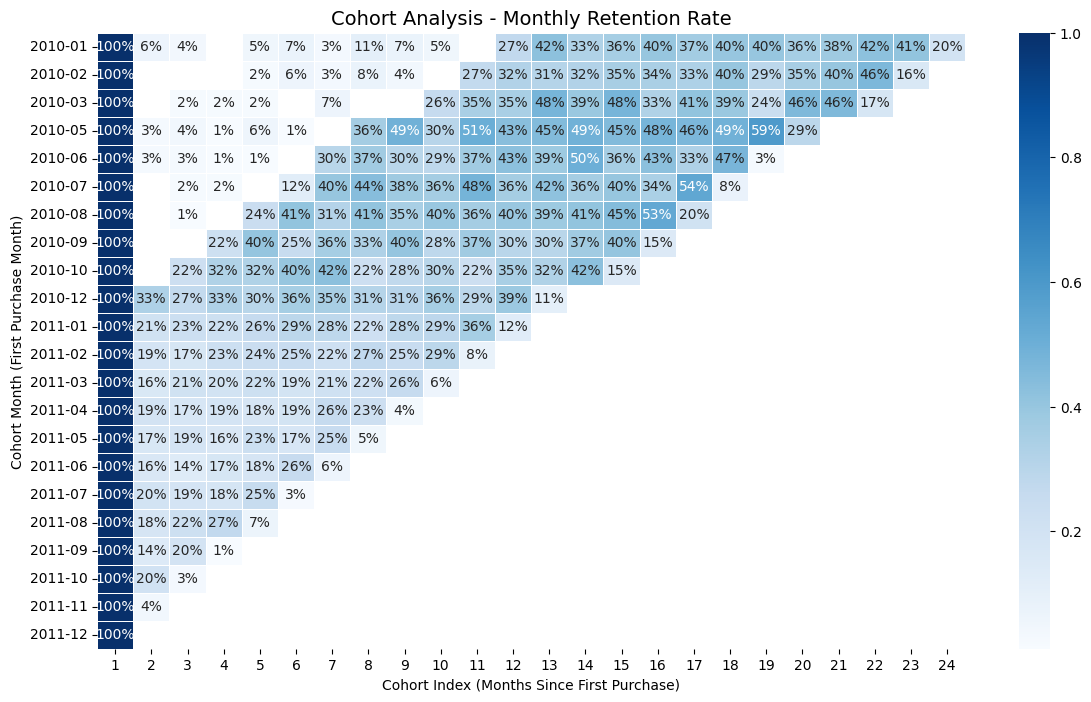

In [ ]:
plt.figure(figsize=(14, 8))

sns.heatmap(
    cohort_retention,
    annot=True,
    fmt=".0%",
    cmap="Blues",
    linewidths=.5
)

plt.title("Cohort Analysis - Monthly Retention Rate", fontsize=14)
plt.xlabel("Cohort Index (Months Since First Purchase)")
plt.ylabel("Cohort Month (First Purchase Month)")
plt.yticks(rotation=0)
plt.show()
